<a href="https://colab.research.google.com/github/sultanbst123/Telco_customer_churn/blob/main/Telco_Costumer_Churn(modelling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install catboost
!pip install borutashap
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from BorutaShap import BorutaShap
 
# classification
import xgboost, lightgbm, catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier, HistGradientBoostingClassifier) 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
 
# regression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                             AdaBoostRegressor, HistGradientBoostingRegressor) 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

#preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            log_loss, roc_auc_score, plot_roc_curve,plot_confusion_matrix) 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.calibration import CalibrationDisplay

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Telco costumers churn/train_churn(clean).csv")
test = pd.read_csv("/content/drive/MyDrive/Telco costumers churn/test_churn(clean).csv")

In [ ]:
df =pd.concat([train, test])

In [ ]:
df.shape

(7026, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7026 entries, 0 to 1408
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7026 non-null   object 
 1   SeniorCitizen     7026 non-null   int64  
 2   Partner           7026 non-null   object 
 3   Dependents        7026 non-null   object 
 4   tenure            7026 non-null   int64  
 5   PhoneService      7026 non-null   object 
 6   MultipleLines     7026 non-null   object 
 7   InternetService   7026 non-null   object 
 8   OnlineSecurity    7026 non-null   object 
 9   OnlineBackup      7026 non-null   object 
 10  DeviceProtection  7026 non-null   object 
 11  TechSupport       7026 non-null   object 
 12  StreamingTV       7026 non-null   object 
 13  StreamingMovies   7026 non-null   object 
 14  Contract          7026 non-null   object 
 15  PaperlessBilling  7026 non-null   object 
 16  PaymentMethod     7026 non-null   object 


In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,No,57,No,No phone service,DSL,Yes,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,53.75,3196.00,No
1,Female,0,Yes,No,15,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,51.10,711.15,No
2,Male,1,Yes,No,2,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,86.85,156.35,Yes
3,Male,0,No,Yes,48,Yes,Yes,DSL,Yes,Yes,Yes,No,No,No,One year,Yes,Bank transfer (automatic),64.40,3035.35,No
4,Male,0,No,No,24,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.10,2322.85,No


In [ ]:
df.Churn.value_counts()

No     5166
Yes    1860
Name: Churn, dtype: int64

In [ ]:
cater = df.select_dtypes("object").drop("Churn", axis=1).columns

In [ ]:
df[cater] = df[cater].astype("category")

In [ ]:
x = df.drop("Churn", axis=1)
y = df.Churn

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=19)

# FEATURE SELECTION

In [ ]:
lg = LGBMClassifier(is_unbalance=True, learning_rate=0.01, random_state=10)

In [ ]:
#feature selection
Feature_Selector = BorutaShap(model=lg,
                              importance_measure='shap', 
                              classification=True)#set True jika classification

In [ ]:
Feature_Selector.fit(X=x_train, y=y_train, n_trials=50, random_state=0)

  0%|          | 0/50 [00:00<?, ?it/s]

10 attributes confirmed important: ['OnlineSecurity', 'InternetService', 'PaperlessBilling', 'StreamingMovies', 'MonthlyCharges', 'tenure', 'PaymentMethod', 'TechSupport', 'Contract', 'TotalCharges']
8 attributes confirmed unimportant: ['DeviceProtection', 'Partner', 'MultipleLines', 'Dependents', 'gender', 'StreamingTV', 'PhoneService', 'SeniorCitizen']
1 tentative attributes remains: ['OnlineBackup']


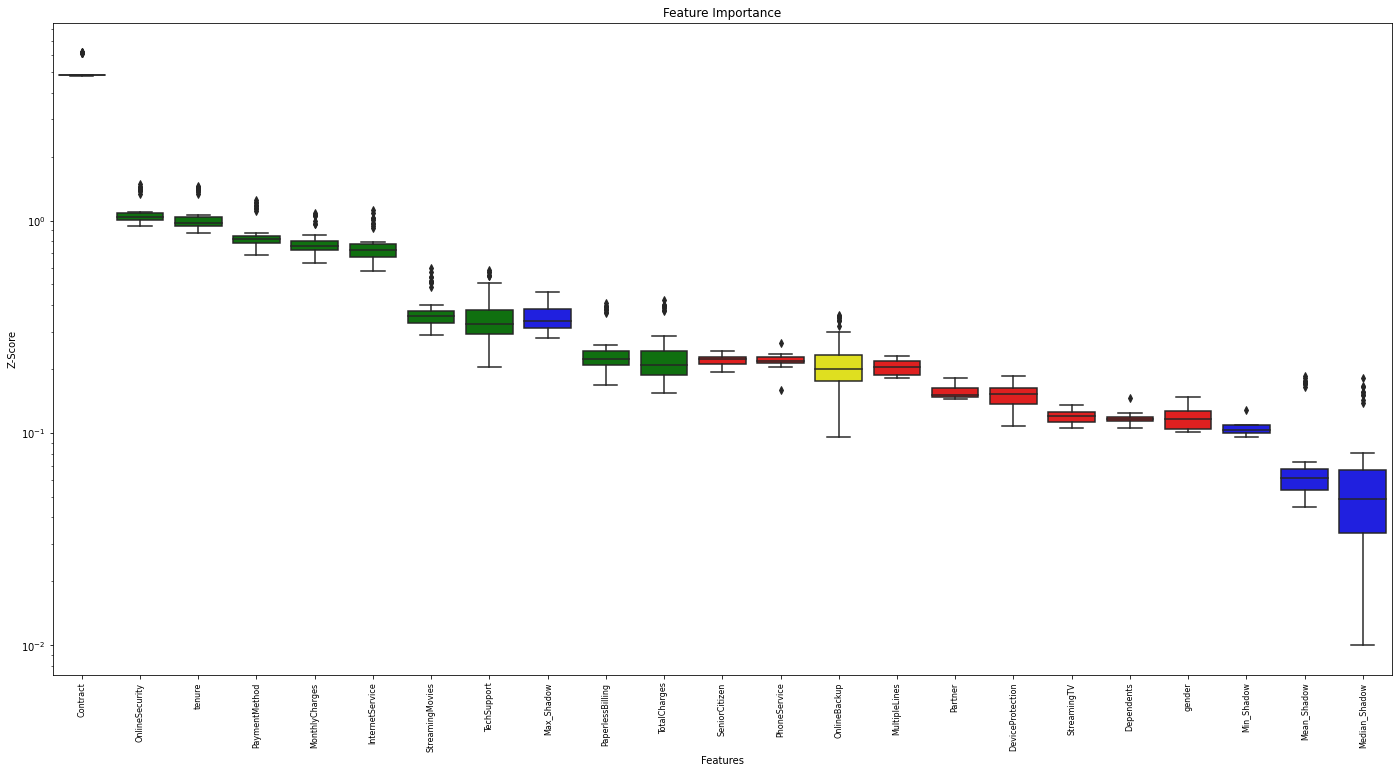

In [ ]:
Feature_Selector.plot(which_features='all', figsize=(24,12))

In [ ]:
col = Feature_Selector.Subset().columns.to_list()

In [ ]:
col

['OnlineSecurity',
 'InternetService',
 'PaperlessBilling',
 'StreamingMovies',
 'MonthlyCharges',
 'tenure',
 'PaymentMethod',
 'TechSupport',
 'Contract',
 'TotalCharges']

In [ ]:
acc_val = []
acc_train = []
roc_auc = []

#MODEL-1

In [ ]:
x_train_1 = x_train[col]
x_val_1 = x_val[col]

In [ ]:
cater = x_train_1.select_dtypes(exclude="number").columns
cater

Index(['OnlineSecurity', 'InternetService', 'PaperlessBilling',
       'StreamingMovies', 'PaymentMethod', 'TechSupport', 'Contract'],
      dtype='object')

In [ ]:
ft = {}
for i in cater:
    ft[i] = LabelEncoder()
    x_train_1[i] = ft[i].fit_transform(x_train_1[i]) 
    x_val_1[i] = ft[i].transform(x_val_1[i])

In [ ]:
x_train_1.dtypes

OnlineSecurity        int64
InternetService       int64
PaperlessBilling      int64
StreamingMovies       int64
MonthlyCharges      float64
tenure                int64
PaymentMethod         int64
TechSupport           int64
Contract              int64
TotalCharges        float64
dtype: object

In [ ]:
XGB = XGBClassifier(learning_rate=0.01,scale_post_weight=2, random_state=10)
GBT = GradientBoostingClassifier(learning_rate=0.01, random_state=20)
HGBT = HistGradientBoostingClassifier(learning_rate=0.01, random_state=30)
ADA = AdaBoostClassifier(learning_rate=0.01, random_state=40)
EXT = ExtraTreeClassifier(random_state=50)
RF = RandomForestClassifier(random_state=60)
DT = DecisionTreeClassifier(random_state=70)

In [ ]:
def score_1(model,x_train, y_train, x_val, y_val):
    #fit model
    model.fit(x_train,y_train)
 
    #score train dan val
    acc_train.append(model.score(x_train, y_train)) 
    acc_val.append(model.score(x_val, y_val)) 
        
    #roc auc score
    pred = model.predict_proba(x_val)[:,-1]
    auc = roc_auc_score(y_val, pred) 
    roc_auc.append(auc) 
    
    return model

In [ ]:
for i in [XGB,ADA,GBT,HGBT,DT,RF,EXT]:
    print(30*"-")
    print(i)
    score_1(i, x_train_1, y_train, x_val_1, y_val)
    print(10*"->" + " DONE")

------------------------------
XGBClassifier(learning_rate=0.01, random_state=10, scale_post_weight=2)
->->->->->->->->->-> DONE
------------------------------
AdaBoostClassifier(learning_rate=0.01, random_state=40)
->->->->->->->->->-> DONE
------------------------------
GradientBoostingClassifier(learning_rate=0.01, random_state=20)
->->->->->->->->->-> DONE
------------------------------
HistGradientBoostingClassifier(learning_rate=0.01, random_state=30)
->->->->->->->->->-> DONE
------------------------------
DecisionTreeClassifier(random_state=70)
->->->->->->->->->-> DONE
------------------------------
RandomForestClassifier(random_state=60)
->->->->->->->->->-> DONE
------------------------------
ExtraTreeClassifier(random_state=50)
->->->->->->->->->-> DONE


#MODEL-2

In [ ]:
x_train_2 = x_train[col]
x_val_2 = x_val[col]

In [ ]:
x_train_2.dtypes

OnlineSecurity      category
InternetService     category
PaperlessBilling    category
StreamingMovies     category
MonthlyCharges       float64
tenure                 int64
PaymentMethod       category
TechSupport         category
Contract            category
TotalCharges         float64
dtype: object

In [ ]:
cater

Index(['OnlineSecurity', 'InternetService', 'PaperlessBilling',
       'StreamingMovies', 'PaymentMethod', 'TechSupport', 'Contract'],
      dtype='object')

In [ ]:
CB = CatBoostClassifier(learning_rate=0.01, scale_pos_weight=2, random_state=12)
LGBM = LGBMClassifier(learning_rate=0.01, is_unbalance=True, random_state=14)

In [ ]:
def score_2(model,x_train, y_train, x_val, y_val):
       
    #lgbm
    if model == LGBM:
       #fit model
       model.fit(x_train,y_train,verbose=False)
 
       #accuracy train dan val
       acc_train.append(model.score(x_train, y_train))
       acc_val.append(model.score(x_val, y_val))
     
       #roc_auc
       pred = model.predict_proba(x_val)[:,-1]
       auc = roc_auc_score(y_val, pred)
       roc_auc.append(auc)
 
   #catboost
    else:         
       model.fit(x_train,y_train,cat_features=cater.to_list(),verbose=False)
 
       #accuracy train dan val
       acc_train.append(model.score(x_train, y_train))
       acc_val.append(model.score(x_val, y_val))
          
       #roc_auc
       pred = model.predict_proba(x_val)[:,-1]
       auc = roc_auc_score(y_val, pred) 
       roc_auc.append(auc)

    return model

In [ ]:
for i in [CB,LGBM]:
    print(30*"-")
    print(i)
    score_2(i, x_train_2, y_train, x_val_2, y_val)
    print(10*"->" + " DONE")

------------------------------
->->->->->->->->->-> DONE
------------------------------
LGBMClassifier(is_unbalance=True, learning_rate=0.01, random_state=14)
->->->->->->->->->-> DONE


#MODEL-3

In [ ]:
x_train_3 = x_train[col]
x_val_3  = x_val[col]

In [ ]:
x_train_3.shape, x_val_3.shape

((5620, 10), (1406, 10))

In [ ]:
x_train_3 = pd.get_dummies(x_train_3)
x_val_3 = pd.get_dummies(x_val_3)

In [ ]:
rs = RobustScaler()
x_train_3.iloc[:,:3] = rs.fit_transform(x_train_3.iloc[:,:3])
x_val_3.iloc[:,:3] = rs.transform(x_val_3.iloc[:,:3])

In [ ]:
x_train_3

,MonthlyCharges,tenure,TotalCharges,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaperlessBilling_No,PaperlessBilling_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
3884,-0.384191,-0.489362,-0.319110,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0
4786,0.271140,-0.319149,-0.076190,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
2549,0.431066,-0.063830,0.288955,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
945,-0.927390,0.702128,-0.045153,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0
565,0.064338,0.042553,0.240635,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5032,0.812500,0.893617,1.969764,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1
1378,0.164522,-0.425532,-0.216666,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0
757,0.035846,0.808511,1.056057,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0
2670,-0.931066,-0.404255,-0.349810,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0


In [ ]:
LR = LogisticRegression(random_state=14)
KNN = KNeighborsClassifier() 
SVM = SVC(kernel="linear",random_state=73,probability=True)

In [ ]:
def score_3(model,x_train, y_train, x_val, y_val):
    #fit model
    model.fit(x_train,y_train)
 
    #score train dan val
    acc_train.append(model.score(x_train, y_train)) 
    acc_val.append(model.score(x_val, y_val)) 
        
    #roc auc score
    pred = model.predict_proba(x_val)[:,-1]
    auc = roc_auc_score(y_val, pred) 
    roc_auc.append(auc) 
    
    return model

In [ ]:
for i in [LR,KNN,SVM]:
    print(30*"-")
    print(i)
    score_3(i, x_train_3, y_train, x_val_3, y_val)
    print(10*"->" + " DONE")

------------------------------
LogisticRegression(random_state=14)
->->->->->->->->->-> DONE
------------------------------
KNeighborsClassifier()
->->->->->->->->->-> DONE
------------------------------
SVC(kernel='linear', probability=True, random_state=73)
->->->->->->->->->-> DONE


# MODEL-SELECTION

In [ ]:
all_models = pd.DataFrame({"models": ["XGB", "ADA", "GBT", "HGBT", "DT", "RF", "EXT","CB","LGBM","LR","KNN","SVC"], 
                          "Train_accuracy": acc_train, 
                          "Val_accuracy": acc_val,
                          "Roc_auc_score": roc_auc})
all_models = all_models.set_index("models")

In [ ]:
all_models

,Train_accuracy,Val_accuracy,Roc_auc_score
models,,,
XGB,0.799110,0.794452,0.817894
ADA,0.734342,0.738976,0.765923
GBT,0.772064,0.768848,0.816952
HGBT,0.803381,0.784495,0.827133
DT,0.996619,0.727596,0.651116
RF,0.996619,0.790896,0.806146
EXT,0.996619,0.748222,0.681230
CB,0.794128,0.773115,0.835798
LGBM,0.809786,0.779516,0.830921


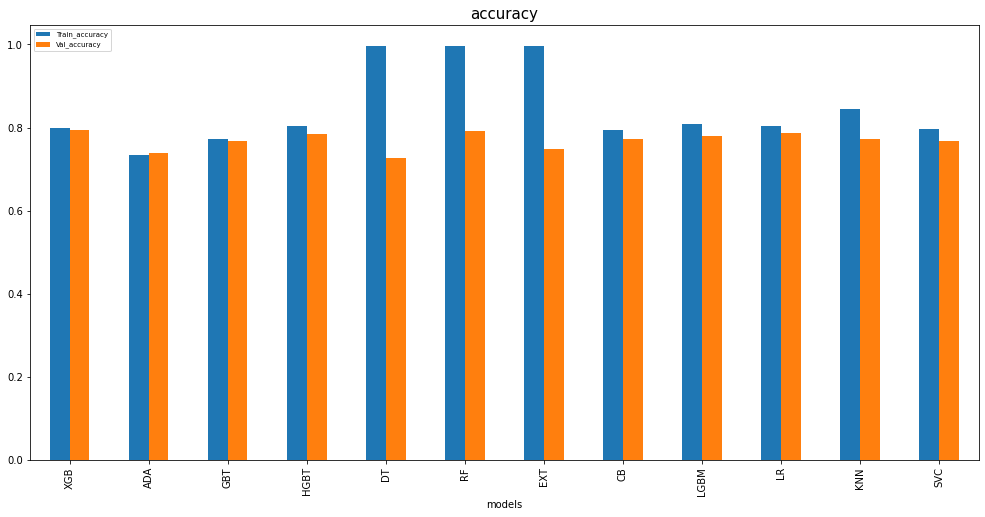

In [ ]:
all_models[["Train_accuracy", "Val_accuracy"]].plot.bar(figsize=(17,8))
plt.title("accuracy", size=15)
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],size=10)
plt.xticks(size=10)
plt.legend(loc=2,fontsize=7)
plt.show()

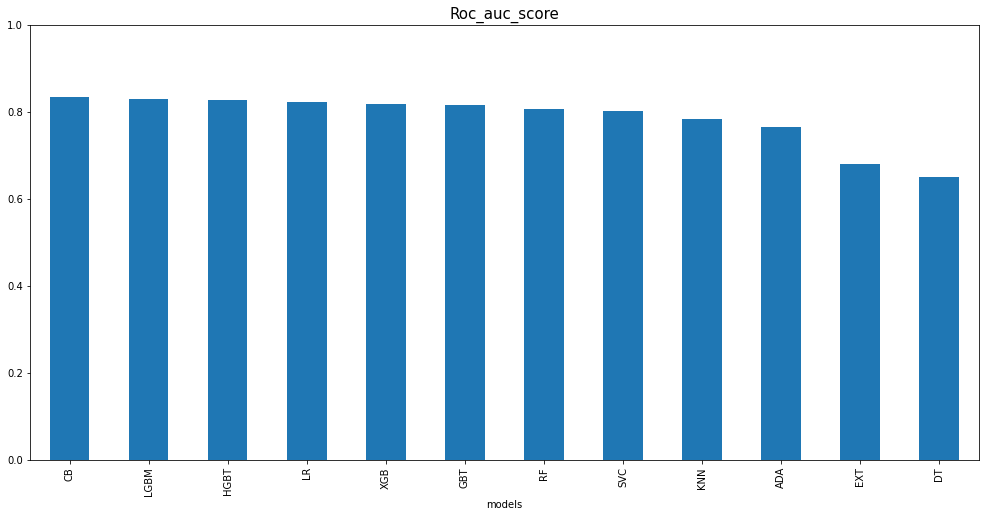

In [ ]:
all_models["Roc_auc_score"].sort_values(ascending=False).plot(kind="bar", figsize=(17, 8))
plt.title("Roc_auc_score", size=15)
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],size=10)
plt.xticks(size=10)
plt.show()

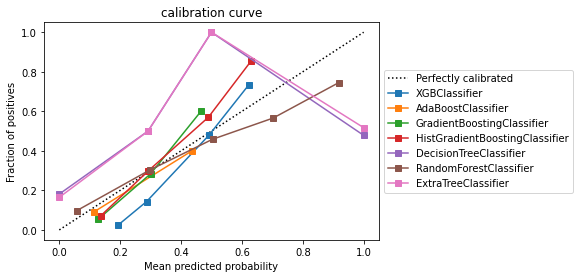

In [ ]:
#model-1
for i in [XGB,ADA,GBT,HGBT,DT,RF,EXT]:
    ax = plt.gca() 
    CalibrationDisplay.from_estimator(i, x_val_1, y_val,ax=ax)

plt.title("calibration curve")
plt.legend(loc="center left",bbox_to_anchor=[1, 0.5]) 
plt.show()

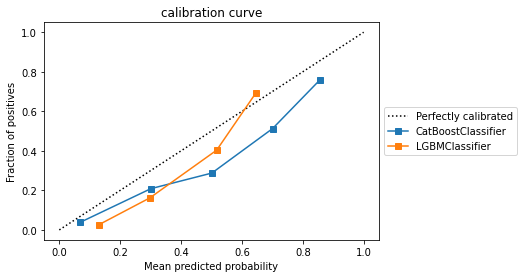

In [ ]:

#model-2
for i in [CB,LGBM]:
    ax = plt.gca() 
    CalibrationDisplay.from_estimator(i, x_val_2, y_val,ax=ax)

plt.title("calibration curve")
plt.legend(loc="center left",bbox_to_anchor=[1, 0.5]) 
plt.show()

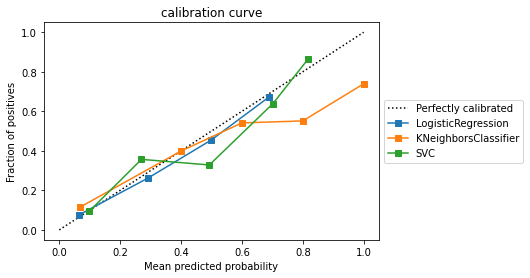

In [ ]:
#model-3
for i in [LR,KNN,SVM]:
    ax = plt.gca() 
    CalibrationDisplay.from_estimator(i, x_val_3, y_val,ax=ax)

plt.title("calibration curve")
plt.legend(loc="center left",bbox_to_anchor=[1, 0.5]) 
plt.show()

# HYPERPARAMETERS-TUNING

In [ ]:
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

params = dict(solver=solvers,penalty=penalty,C=c_values)

In [ ]:
grid_search = GridSearchCV(estimator=lr, param_grid=params, n_jobs=-1,scoring="accuracy")
result = grid_search.fit(x_train_3, y_train)

In [ ]:
print(f"Best: {result.best_score_} using {result.best_params_}")

Best: 0.80355871886121 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
lr_params = result.best_params_

#CROSS - VALIDATION

In [ ]:
#stratified for imbalance target
def cross_val(X, y, model, params, folds=5):

    score = []
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold+1}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
 
        alg = model(**params)
        alg.fit(x_train, y_train)
 
        pred = alg.predict(x_test)
        loss = accuracy_score(y_test, pred)
        score.append(loss)

        print(f" accuracy_score: {loss}")
        print("-"*50)
     
    print("mean:",np.array(score).mean())

    return alg

In [ ]:
score_lr = cross_val(x_train_3, y_train, LogisticRegression, lr_params)

Fold: 1
 accuracy_score: 0.7882562277580071
--------------------------------------------------
Fold: 2
 accuracy_score: 0.8096085409252669
--------------------------------------------------
Fold: 3
 accuracy_score: 0.8140569395017794
--------------------------------------------------
Fold: 4
 accuracy_score: 0.8131672597864769
--------------------------------------------------
Fold: 5
 accuracy_score: 0.7953736654804271
--------------------------------------------------
mean: 0.8040925266903913


In [ ]:
pred = score_lr.predict(x_val_3)

In [ ]:
classification_report(pred, y_val)

'              precision    recall  f1-score   support\n\n          No       0.88      0.84      0.86      1092\n         Yes       0.52      0.61      0.56       314\n\n    accuracy                           0.79      1406\n   macro avg       0.70      0.72      0.71      1406\nweighted avg       0.80      0.79      0.79      1406\n'

Text(0.5, 1.0, 'ROC AUC SCORE')

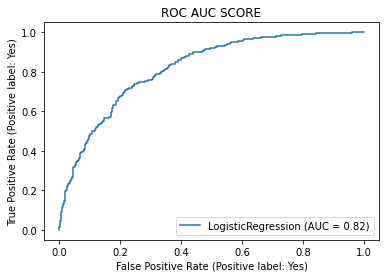

In [ ]:
plot_roc_curve(score_lr, x_val_3, y_val)
plt.title("ROC AUC SCORE")

Text(0.5, 1.0, 'CONFUSION MATRIX')

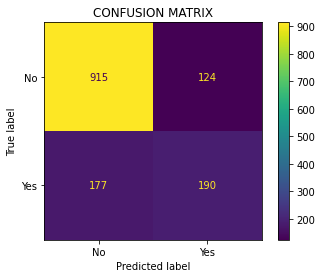

In [ ]:
plot_confusion_matrix(score_lr, x_val_3, y_val)
plt.title("CONFUSION MATRIX")

In [ ]:
print(f"accuracy training: {score_lr.score(x_train_3, y_train)}")
print(f"accuracy validation: {score_lr.score(x_val_3, y_val)}")

accuracy training: 0.8026690391459075
accuracy validation: 0.7859174964438123
